# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import math
import os

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
def extrapolate_lines(lines,y_min,y_max):
    """ Function to identify valid lane lines by detecting only lines that look vertical based on slope and extending them. """
    def valid_line(x1,y1,x2,y2,threshold_slope=0.25):
        target_slope=(y2-y1)/float(x2-x1)
        if x1==x2:
            return False
        if target_slope >= threshold_slope: #Lane Line 1
            return True
        elif target_slope <= -threshold_slope: # Lane Line 2
            return True
        else:
            return False
    
    
    lines_list=[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Check if line is vertical
            if valid_line(x1,y1,x2,y2):
                #Extrapolate line
                slope=(y2-y1)/float(x2-x1)
                x_max=((y_max-y1)/slope)+x1
                x_min=((y_min-y1)/slope)+x1
                # Return extrapolated lines
                lines_list.append([int(x_min),int(y_min),int(x_max),int(y_max)])
    
    return lines_list

In [3]:
import math

def hsv(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    return s_channel

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines,y_min,y_max,color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #Line image
    img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    ysize,xsize,_=img.shape
    threshold_distance=5
    lines=extrapolate_lines(lines,y_min,y_max)
    
    for line in lines:
        x1=line[0]
        y1=line[1]
        x2=line[2]
        y2=line[3]
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return lines,img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    Returns line segments detected byHough Transform
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


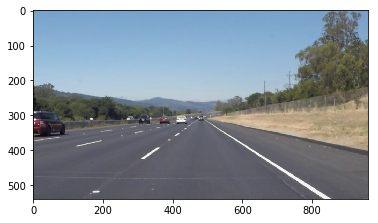

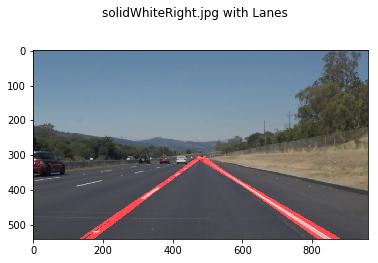

In [95]:
#reading in an image
file='solidWhiteRight.jpg'
image = mpimg.imread('test_images/'+file)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
fig = plt.figure("Original")
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
lines,image_with_lanes=find_lane(image)
fig = plt.figure()
fig.suptitle(file+" with Lanes")
plt.imshow(image_with_lanes)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

run your solution on all test_images and make copies into the test_images directory).

In [7]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
kernel_size = 5
def find_lane(img):
    ysize,xsize,_=img.shape
    LANE_Y_MIN=0.57*ysize
    LANE_Y_MAX=ysize
    img_copy=np.copy(img)

    # Convert to gray scale
    gray=grayscale(img_copy)    
    
    # Add blur to the image

    blur_gray = gaussian_blur(gray,kernel_size)

    # Apply Canny, 1:3 ratio between low and high

    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    
    # Determine Region of Interest
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    left_bottom = (0.15*xsize, LANE_Y_MAX)##0.15
    right_bottom = (0.85*xsize, LANE_Y_MAX)#0.85
    left_top=(0.475*xsize,LANE_Y_MIN)
    right_top=(0.525*xsize,LANE_Y_MIN)
    #Initial triangle mask
    #apex = [xsize/2, (ysize/2)]#apex = [xsize/2, (ysize/2)+40]
    #triangle=np.array([left_bottom,right_bottom,apex],np.int32)

    #4 sided polygon mask
    vertices = np.array([[left_bottom,right_bottom, right_top,left_top]], dtype=np.int32)
    masked_edges=region_of_interest(edges,vertices)
  
    # Hough Transform
    rho = 2
    theta = np.pi/180
#    threshold = 15#,50
#    min_line_length = 10 #5 I want small lines
#    max_line_gap = 20
    threshold = 50
    min_line_length  = 100
    max_line_gap = 160
    lines=hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    lines,line_img=draw_lines(masked_edges,lines,LANE_Y_MIN,LANE_Y_MAX,thickness=5)
    # Create a "color" binary image to combine with line image
    final_img = weighted_img(line_img,img_copy)
    return lines,final_img

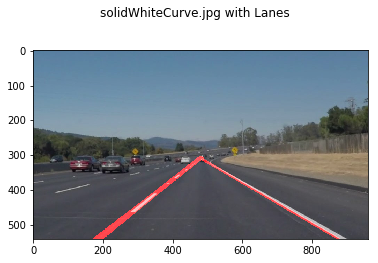

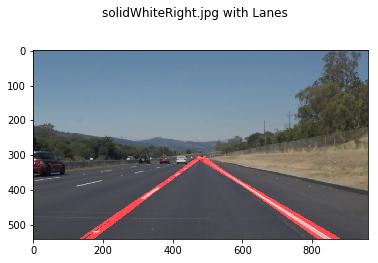

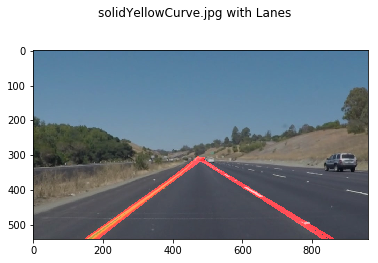

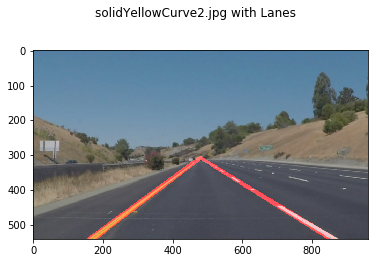

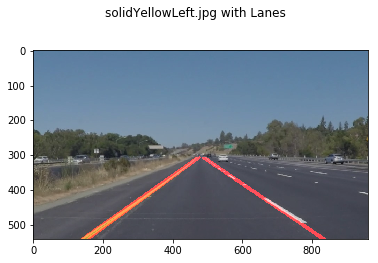

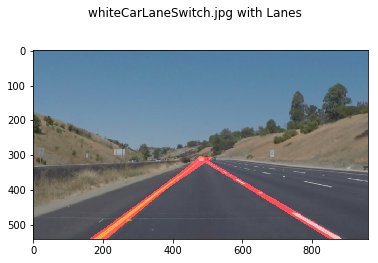

In [96]:
list_of_images=['solidWhiteCurve.jpg',
                'solidWhiteRight.jpg',
                'solidYellowCurve.jpg',
                'solidYellowCurve2.jpg',
                'solidYellowLeft.jpg',
                'whiteCarLaneSwitch.jpg']

for file in list_of_images:
    image=mpimg.imread('test_images/'+file)
    lines,image_with_lanes=find_lane(image)
    fig = plt.figure()
    fig.suptitle(file+" with Lanes")
    plt.imshow(image_with_lanes)
    mpimg.imsave("test_images/lane_"+file,image_with_lanes)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

2017-04-03 09:08:04  - py.warnings - WARNING - /Users/aravind/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



In [5]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    #print ("Image shape",image.shape)
    lines,image_with_lanes=find_lane(image)
    return image_with_lanes

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:04<00:00, 44.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.33 s, sys: 297 ms, total: 2.62 s
Wall time: 5.78 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [90]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:28<00:00, 23.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 8.54 s, sys: 953 ms, total: 9.49 s
Wall time: 29.7 s


In [92]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

I found it to be a challenging first assignment. I started reviewing the course material on Monday and spent around 6 hours on the project.

I had fun learning about Hough Transform and Canny Edge Detection. I think I had some success with identifying lane segments but didn't get a chance to complete the extrapolation of the lines.

My approach was as follows:
1. Gray scale
2. Canny Edge Detection
3. Identify region of interest - Polygon determined proportional to size(room for improvement)
4. Hough Transform
5. Identifying Two Lanes by splitting segments into two groups
One with positive and one with negative slope and eliminating lines which are too different from the most frequent/common slopes.

I made some assumptions to simplify the problem which may not hold in the real world. I think my approach will have to be refined quite a bit to handle real world complexities.

The first assumption I made is around the region of interest. I hard-coded the region of interest to be a polygon. This won't work in the real world as evidenced by the performance of my approach in the challenge video problem.

The second assumption I made that the two lane lines have different slopes. This is not always true as shown by the challenge video problem. I need to generalize my routine to detect the lines with the most common slope in those scenarios.

My pipeline also identifie lane markings outside the lane of interest. I spent a fair amount of time trying to tweak the parameters to Hough Transform to eliminate them. But I think refining the region of interest will be beneficial in this case as well.

I also eliminated lane segments with zero slope and infinite slope. 
This approach will clearly fail when we need to make a right or left turn when we need to recognize lanes which have zero slope.

Another assumption here is that there will be some some markings on the image. 
For highways, this is okay but this approach may fail in neighborhoods or if the stretch of the road immediately in front of the camera doesn't have lane markings. In those cases, we may have to either extrapolate from the previous image(s) seen by the camera.  

Overall, I enjoyed the assignment and wish I had spent more time on it! Thank you for the interesting material and the  project. I look forward to learning more.



## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [93]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

2017-01-26 11:12:31  - py.warnings - WARNING - /Users/aravind/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/moviepy/audio/io/readers.py:123: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.nchannels))

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:18<00:00, 13.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 10.9 s, sys: 1.17 s, total: 12.1 s
Wall time: 19.9 s


In [94]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))